In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train = pd.read_excel("covid19.xlsx")

In [30]:
label_encoder = LabelEncoder().fit(train.Death)
labels = label_encoder.transform(train.Death)
classes = list(label_encoder.classes_)

train = train.drop(["Death"],axis=1)

nb_features = 38
nb_classes = len(classes)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train.values)
train = scaler.transform(train.values)


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train, labels, test_size=0.3)
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [32]:
X_train = np.array(X_train).reshape(223,38,1)
X_valid = np.array(X_valid).reshape(96,38,1)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Dropout, MaxPooling1D, Flatten, BatchNormalization

model = Sequential()
model.add(Conv1D(512,1,input_shape=(nb_features,1)))
model.add(Activation("relu"))
model.add(MaxPooling1D(2))
model.add(Conv1D(256,1))
model.add(Activation("relu"))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())
model.add((Flatten()))
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(nb_classes, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 38, 512)           1024      
                                                                 
 activation_4 (Activation)   (None, 38, 512)           0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 19, 512)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 19, 256)           131328    
                                                                 
 activation_5 (Activation)   (None, 19, 256)           0         
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 9, 256)            0         
 g1D)                                                 

In [34]:
from tensorflow.keras.optimizers.legacy import SGD
opt = SGD(lr=1e-3, decay=1e-5, momentum=0.3, nesterov=True)

c:\Users\TerfiBilisim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [35]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [36]:
#compile the model
model.compile(loss="binary_crossentropy", optimizer = "adam", metrics=["accuracy",f1_m,precision_m,recall_m])

In [37]:
#run the model
score = model.fit(X_train, y_train, epochs = 100, validation_data=(X_valid,y_valid))

Epoch 1/100
7/7 [==============================] - 1s 72ms/step - loss: 0.3381 - accuracy: 0.8520 - f1_m: 0.8527 - precision_m: 0.8527 - recall_m: 0.8527 - val_loss: 0.5192 - val_accuracy: 0.8854 - val_f1_m: 0.8854 - val_precision_m: 0.8854 - val_recall_m: 0.8854
Epoch 2/100
7/7 [==============================] - 0s 42ms/step - loss: 0.1920 - accuracy: 0.9552 - f1_m: 0.9552 - precision_m: 0.9552 - recall_m: 0.9552 - val_loss: 0.5402 - val_accuracy: 0.8854 - val_f1_m: 0.8854 - val_precision_m: 0.8854 - val_recall_m: 0.8854
Epoch 3/100
7/7 [==============================] - 0s 41ms/step - loss: 0.1515 - accuracy: 0.9507 - f1_m: 0.9505 - precision_m: 0.9505 - recall_m: 0.9505 - val_loss: 0.5594 - val_accuracy: 0.8854 - val_f1_m: 0.8854 - val_precision_m: 0.8854 - val_recall_m: 0.8854
Epoch 4/100
7/7 [==============================] - 0s 45ms/step - loss: 0.1318 - accuracy: 0.9552 - f1_m: 0.9554 - precision_m: 0.9554 - recall_m: 0.9554 - val_loss: 0.5036 - val_accuracy: 0.8854 - val_f1_m: 

In [38]:
y_score = model.predict((X_valid))

3/3 [==============================] - 0s 6ms/step


In [39]:
print(("Average Training loss: ", np.mean(score.history["loss"])))
print(("Average Training Accuracy: ", np.mean(score.history["accuracy"])))
print(("Average Validation loss: ", np.mean(score.history["val_loss"])))
print(("Average Validation Accuracy: ", np.mean(score.history["val_accuracy"])))
print(("Average F1-Score: ", np.mean(score.history["val_f1_m"])))
print(("Average Precision: ", np.mean(score.history["val_precision_m"])))
print(("Average Recall: ", np.mean(score.history["val_recall_m"])))

('Average Training loss: ', 0.07913391761481763)
('Average Training Accuracy: ', 0.9726905739307403)
('Average Validation loss: ', 0.4744701635837555)
('Average Validation Accuracy: ', 0.8873958349227905)
('Average F1-Score: ', 0.887395806312561)
('Average Precision: ', 0.8873958349227905)
('Average Recall: ', 0.8873958349227905)


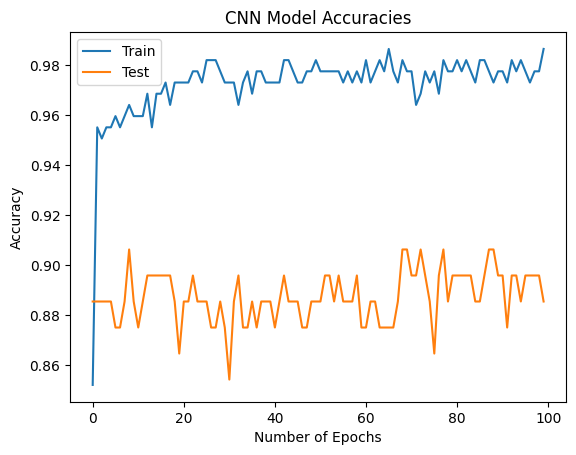

In [40]:
import matplotlib.pyplot as plt
res = plt.figure()
plt.plot(score.history["accuracy"])
plt.plot(score.history["val_accuracy"])
plt.title("CNN Model Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend(["Train","Test"], loc="upper left")
plt.show()


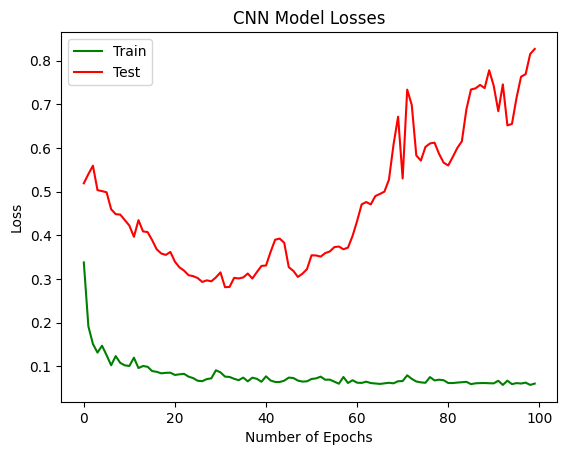

In [41]:
res2 = plt.figure()
plt.plot(score.history["loss"],color="g")
plt.plot(score.history["val_loss"],color="r")
plt.title("CNN Model Losses")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend(["Train","Test"], loc="upper left")
plt.show()

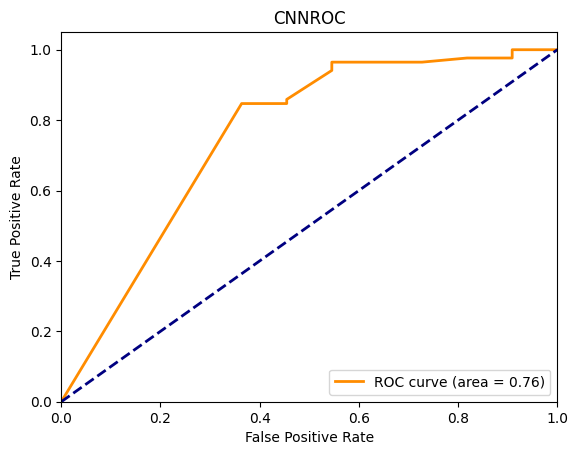

C:\Users\TerfiBilisim\AppData\Local\Temp\ipykernel_8228\3166293315.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
C:\Users\TerfiBilisim\AppData\Local\Temp\ipykernel_8228\3166293315.py:54: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='-.')


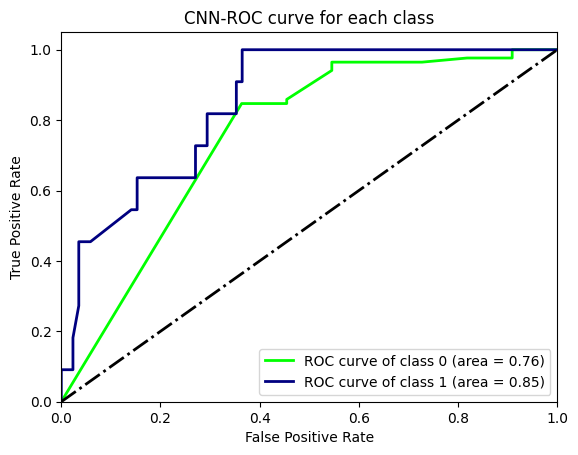

In [42]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNNROC')
plt.legend(loc="lower right")
plt.show()

from itertools import cycle
from scipy import interp

lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))


mean_tpr = np.zeros_like(all_fpr)
for i in range(nb_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])


mean_tpr /= nb_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


res3 = plt.figure()

colors = cycle(['lime', 'navy', 'gold', 'orchid', 'orangered'])
for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN-ROC curve for each class')
plt.legend(loc="lower right")
plt.show()